# Vignetting correction

Authors:
* [Quentin Kaci](https://github.com/quentinkaci/)
* [Ilan Guenet](https://github.com/Li0nMo0se)

Implementation from the paper [Revisiting Image Vignetting Correction by Constrained Minimization of Log-Intensity Entropy](https://www.researchgate.net/publication/300786398_Revisiting_Image_Vignetting_Correction_by_Constrained_Minimization_of_Log-Intensity_Entropy)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

## Introduction

The vignetting correction can be performed in several ways. Some solutions use a white reference picture to compute the vignetting correction partially and apply it to other images. Other solutions are simply based on the image to correct but are slower. For this exercise, we consider that we don't have a white reference picture, and, therefore, we chose the single image-based method.

## Algorithm steps 

The chosen method contains several steps in order to perform the vignetting correction:
- Convert color image to gray scale
- Compute the optical center of the image
- Compute the radius matrix: the distance of each pixel to the optical center
- Minimize the log-intensity entropy based on polynomial parameters
- Multiply all image channels by the found polynomial that has the lowest log-intensity entropy

### Log-intensity entropy

The log-intensity entropy computes how messy the intensity is within the image. Therefore, less the log-intensity entropy is low better the image is. That is why the algorithm will try to minimize this log-intensity entropy. 

In [18]:
def log_entropy(image, sigma_smooth=2.25):
  N = 256
  n_hist = np.zeros(N, dtype=float)

  rescaled_image = (N - 1) * (image / image.max())
  li = (N - 1) * np.log2(1 + rescaled_image) / np.log2(N)
  li_floor = np.floor(li).astype(int)
  li_ceil = np.ceil(li).astype(int)

  np.add.at(n_hist, li_floor, 1 + li_floor - li)
  np.add.at(n_hist, li_ceil, li_ceil - li)

  n_hist_smooth = gaussian_filter(n_hist, sigma_smooth)

  pk = n_hist_smooth / np.sum(n_hist_smooth)
  log_pk = np.where(pk != 0, np.log2(pk), 0)

  return - np.sum(pk * log_pk)

### Compute the optical center of the image

From the paper:

![](https://i.imgur.com/azVQMtd.png)

In [19]:
def compute_center_of_mass(image):
  (sum, i_sum, j_sum) = (0, 0, 0)

  for j in range(image.shape[0]):
    for i in range(image.shape[1]):
      sum += image[j, i]

      i_sum += (i + 1) * image[j, i]
      j_sum += (j + 1) * image[j, i]

  return (i_sum / sum, j_sum / sum)

### Compute the radius matrix

This matrix compute the distance from each pixel to the optical center of the image

In [20]:
def compute_r_matrix(image):
  (i_mid, j_mid) = compute_center_of_mass(image)

  res = np.empty_like(image, dtype=float)

  d = np.sqrt(i_mid**2 + j_mid**2)

  for j in range(image.shape[0]):
    for i in range(image.shape[1]):
      res[j, i] = np.sqrt((i - i_mid)**2 + (j - j_mid)**2) / d

  return res

### Polynomial

This is the filter applied on the grayscale image. The algorithm update this polynomial function t(`a`, `b` and `c` variable) to reduce the log-intensity entropy

In [21]:
def g(r, a, b, c):
  return 1 + a * r**2 + b * r**4 + c * r**6

### Verify constraints

Those constraints push the polynomial function to keep a gaussian look. If the constraints are fulfilled, consider this polynomial function. If not, look for another polynomial function.

In [22]:
def verify_constraints(a, b, c):
  if a > 0 and b == 0 and c == 0:
      return True
  if a >= 0 and b > 0 and c == 0:
      return True
  if c == 0 and b < 0 and -a <= 2 * b:
      return True
  if c > 0 and b**2 < 3 * a * c:
      return True
  if c > 0 and b**2 == 3 * a * c and b >= 0:
      return True
  if c > 0 and b**2 == 3 * a * c and -b >= 3 * c:
      return True
  if c == 0:
      return False
  q_p = (-2 * b + np.sqrt(4 * b**2 - 12 * a * c)) / (6 * c)
  if c > 0 and b**2 > 3 * a * c and q_p <= 0:
      return True
  q_d = (-2 * b - np.sqrt(4 * b**2 - 12 * a * c)) / (6 * c)
  if c > 0 and b**2 > 3 * a * c and q_d >= 1:
      return True
  if c < 0 and b**2 > 3 * a * c and q_p >= 1 and q_d <= 0:
      return True

  return False

## Overall algorithm

In [23]:
def rgb_to_luminance(image):
  return 0.2126 * image[...,0] + 0.7152 * image[...,1] + 0.0722 * image[...,2]

1. Compute the grayscale image
2. Start with a delta = 8
3. While `delta` is large enough
    1. Get all the possible values for `a`, `b`, `c` updated with `delta`
    2. Find the minimum entropy from all the possible polynomial functions (with `a`, `b` and `c` as parameters)
    3. Reduce delta
    4. Continue
4. Applied the filter/polynomial function found to each RGB channel

In [24]:
def correct_vignetting(image):
  """
  Apply vignetting correction

  Parameters
  ----------
  image : np.arrray
    The input image to be corrected

  Returns
  -------
  np.array
    The corrected image (array like `image`)
  """
  gray_image = rgb_to_luminance(image)

  (a, b, c) = (0.0, 0.0, 0.0)
  delta = 8.0
  h_min = log_entropy(gray_image)
  r = compute_r_matrix(gray_image)

  while delta > 1 / 256:
    v_arr = np.array([(a + delta, b, c), (a - delta, b, c),
                      (a, b + delta, c), (a, b - delta, c),
                      (a, b, c + delta), (a, b, c - delta)])

    for v in v_arr:
      if verify_constraints(*v):
        h_tmp = log_entropy(gray_image * g(r, *v))
        if h_tmp < h_min:
          h_min = h_tmp
          (a, b, c) = v
          delta = 16.0

    delta /= 2.0

  print(f"Coefficients: ({a}, {b}, {c}), Minimal entropy: {h_min}")

  plt.imshow(g(r, a, b, c))
  plt.show()

  res = image * np.stack(3 * [g(r, a, b, c)], axis=2)

  return np.clip(res, 0, 255).astype(np.uint8)

## Results

In [25]:
image = plt.imread('img/sample-1.jpg')

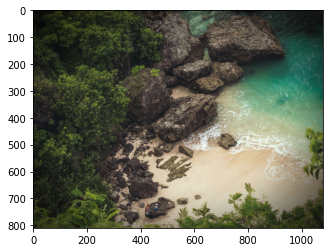

In [26]:
plt.imshow(image)

<ipython-input-18-c1260d405c61>:16: RuntimeWarning: divide by zero encountered in log2
  log_pk = np.where(pk != 0, np.log2(pk), 0)


Coefficients: (1.0234375, 5.5, 0.0), Minimal entropy: 6.51179743945137


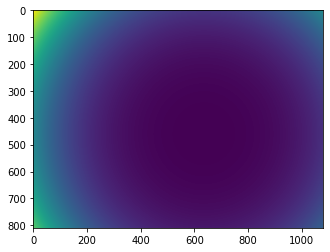

In [27]:
corrected_image = correct_vignetting(image)
plt.imsave('img/sample-1-corrected.jpg', corrected_image)

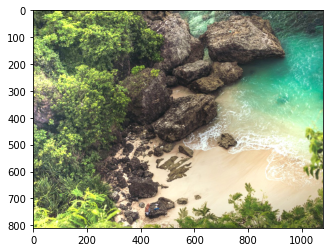

In [28]:
plt.imshow(corrected_image)

In [29]:
image = plt.imread('img/sample-2.jpg')

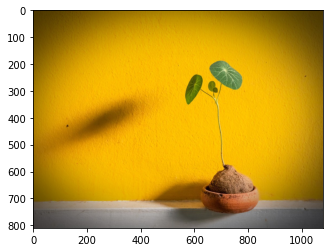

In [30]:
plt.imshow(image)

<ipython-input-18-c1260d405c61>:16: RuntimeWarning: divide by zero encountered in log2
  log_pk = np.where(pk != 0, np.log2(pk), 0)


Coefficients: (0.0, 0.0, 2.5625), Minimal entropy: 4.817998311866629


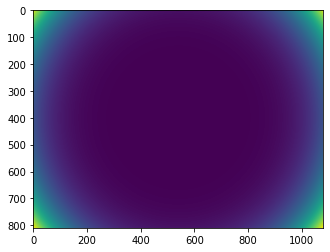

In [31]:
corrected_image = correct_vignetting(image)
plt.imsave('img/sample-2-corrected.jpg', corrected_image)

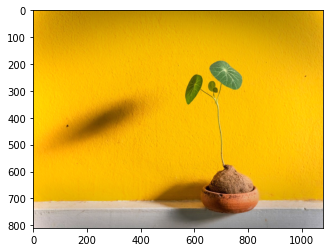

In [32]:
plt.imshow(corrected_image)

## Conclusion

The method that we implemented works well on several images. Moreover, it takes into account that the center of the image is not necessarily the optical center. Therefore, if the vignetting is not centered, our solution will still work.

The improvements of our solution can be focused on the optimization part. Indeed, the method that we use is quite slow because it performs a minimization for each image to be corrected. This process could be improved with for example a parallization of the optimization.